In [41]:
using ReactionMechanismSimulator
using PyPlot
using Sundials
using SciMLBase
using QuadGK

In [42]:
outdict = readinput("chem300.rms")


[06:16:05] WARNING: not removing hydrogen atom without neighbors
[06:16:05] WARNING: not removing hydrogen atom without neighbors
┌ Warning: failed to generate StokesDiffusivity model for species vacantX
└ @ ReactionMechanismSimulator /home/ssun30/RMG-electrocat/ReactionMechanismSimulator.jl/src/Parse.jl:352
┌ Warning: failed to generate StokesDiffusivity model for species CO2X
└ @ ReactionMechanismSimulator /home/ssun30/RMG-electrocat/ReactionMechanismSimulator.jl/src/Parse.jl:352
┌ Warning: failed to generate StokesDiffusivity model for species CHO2X
└ @ ReactionMechanismSimulator /home/ssun30/RMG-electrocat/ReactionMechanismSimulator.jl/src/Parse.jl:352
┌ Warning: failed to generate StokesDiffusivity model for species CO2HX
└ @ ReactionMechanismSimulator /home/ssun30/RMG-electrocat/ReactionMechanismSimulator.jl/src/Parse.jl:352
┌ Warning: failed to generate StokesDiffusivity model for species OCX
└ @ ReactionMechanismSimulator /home/ssun30/RMG-electrocat/ReactionMechanismSimulator.j

Dict{Any, Any} with 4 entries:
  "Solvents"              => Solvent[Solvent("water", RiedelViscosity{Float64}(…
  Set(["surface", "gas"]) => Dict{Any, Any}("Reactions"=>ElementaryReaction[vac…
  "gas"                   => Dict{Any, Any}("Species"=>Species[Species{NASA{Emp…
  "surface"               => Dict{Any, Any}("Species"=>Species[Species{NASA{Emp…

In [43]:
boundarylayerspcs = outdict["gas"]["Species"]
boundarylayerrxns = outdict["gas"]["Reactions"]
surfspcs = outdict["surface"]["Species"]
surfrxns = outdict["surface"]["Reactions"]
interfacerxns = outdict[Set(["surface", "gas"])]["Reactions"]
solv = outdict["Solvents"][1];

In [44]:
sitedensity = 2.292e-5; # Ag111
boundarylayer = IdealDiluteSolution(boundarylayerspcs,boundarylayerrxns,solv,name="boundarylayeruid",diffusionlimited=true);
surf = IdealSurface(surfspcs,surfrxns,sitedensity,name="surface");

In [ ]:
initialcondsboundarylayer = Dict(["proton"=>10.0^-4,
                                  "CO2"=>10.0^-3*10^6,
                                  "V"=>1.0e-3,"T"=>300,"Phi"=>0.0,"d"=>0.0]);
initialcondsreservoir = Dict(["proton"=>10.0^-4,
                              "CO2"=>10.0^-3*10^6,
                              "V"=>1.0,"T"=>300]);
AVratio = 1e5;
initialcondssurf = Dict(["CO2X"=>0.4*sitedensity*AVratio,
#         "CHO2X"=>0.1*sitedensity*AVratio,
#         "CO2HX"=>0.1*sitedensity*AVratio,
#         "OX"=>0.1*sitedensity*AVratio,
#         "OCX"=>0.1*sitedensity*AVratio,
        "vacantX"=>1.0*sitedensity*AVratio,
#         "CH2O2X"=>0.05*sitedensity*AVratio,
#         "CHOX"=>0.04*sitedensity*AVratio,
#         "CH2OX"=>0.01*sitedensity*AVratio,
        "A"=>1.0*AVratio,"T"=>300,"Phi"=>-1.0]);

In [46]:
domainboundarylayer, y0boundarylayer, pboundarylayer = ConstantTVDomain(phase=boundarylayer, initialconds=initialcondsboundarylayer);
domaincat,y0cat,pcat = ConstantTAPhiDomain(phase=surf,
    initialconds=initialcondssurf);

In [47]:
inter,pinter = ReactiveInternalInterfaceConstantTPhi(domainboundarylayer,
  domaincat,interfacerxns,298.15,AVratio*1.0);

In [48]:
# start with 1mm layer thickness
diffusionlayer = ConstantReservoirDiffusion(domainboundarylayer, initialcondsreservoir, AVratio*1.0, 1e-3);

In [49]:
interfaces = [inter, diffusionlayer];

In [50]:
@time react,y0,p = Reactor((domainboundarylayer,domaincat), (y0boundarylayer,y0cat), (0.0, 100.0), interfaces, (pboundarylayer,pcat,pinter));


  0.067722 seconds (61.60 k allocations: 139.523 MiB, 21.90% gc time)


In [51]:
@time sol = solve(react.ode,Sundials.CVODE_BDF(),abstol=1e-16,reltol=1e-6);

  4.182686 seconds (3.17 M allocations: 10.057 GiB, 23.77% gc time)


In [52]:
sol.t[end]

100.0

In [53]:
sol.retcode

ReturnCode.Success = 1

In [54]:
ssys = SystemSimulation(sol,(domainboundarylayer,domaincat,), interfaces,p);

In [55]:
plotmolefractions(ssys.sims[1], 0.99e2,tol=1e-25)
yscale("log")
xscale("log")

In [56]:
plotmolefractions(ssys.sims[2], 0.99e2,tol=3e-2)
xscale("log")

In [57]:
"""
diffusive flux to the reservoir
"""
function flux_to_reservoir(sim,t,reservoirinterface)
    cs = concentrations(sim,t)
    return reservoirinterface.A .* sim.domain.diffusivity .* (cs - reservoirinterface.c) / reservoirinterface.layer_thickness
end

"""
Integrates the flux to the reservoir and computes the concentration assuming
there is no prior concentration of that species in the reservoir
"""
function get_reservoir_concentration(sim,t,reservoirinterface,Vres)
    intg,err = quadgk(x -> flux_to_reservoir(sim,x,reservoirinterface), 0, t)
    return intg./Vres
end

get_reservoir_concentration

In [58]:
flux_to_reservoir(ssys.sims[1],0.99e2,diffusionlayer)

108-element Vector{Float64}:
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  2.127051950376656e-25
 -3.510243060654668e-24
 -8.96648312396144e-32
  ⋮
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0

In [59]:
res_cs = get_reservoir_concentration(ssys.sims[1],0.99e2,diffusionlayer,1.0)

108-element Vector{Float64}:
   0.0
   0.0
   0.0
   0.0
 999.0002936231041
   9.990001587581694e-5
   0.0
  -1.467825103225412e-21
  -6.296704606711658e-22
  -8.269101685197958e-22
   ⋮
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0

In [60]:
sort(res_cs)

108-element Vector{Float64}:
  -3.510028156283103e-20
  -1.467825103225412e-21
  -8.269101685197958e-22
  -6.296704606711658e-22
  -4.143209291884549e-22
  -2.4664908632623496e-22
  -1.4501328070805046e-22
  -2.4297366095524073e-24
  -4.26741575269268e-27
  -1.7565743538985845e-30
   ⋮
   2.9311480681523782e-24
   6.298841337396956e-23
   1.2552996666635814e-22
   3.8512926576472575e-22
   1.2001691194545139e-21
   1.9879062943569044e-21
   6.998718825476003e-21
   9.990001587581694e-5
 999.0002936231041

In [61]:
getfield.(ssys.sims[1].domain.phase.species,:name)

108-element Vector{String}:
 "Ar"
 "He"
 "Ne"
 "N2"
 "CO2"
 "proton"
 "H"
 "C=O"
 "O=CO"
 "H2O"
 ⋮
 "CCOCO"
 "CCCOO"
 "CCC"
 "CCOOC"
 "C=C=COO"
 "CC=COO"
 "C=CCO[O]"
 "COCOC"
 "COCCO"

In [62]:
getfield.(ssys.sims[2].domain.phase.species,:name)

192-element Vector{String}:
 "vacantX"
 "CO2X"
 "CHO2X"
 "CO2HX"
 "OCX"
 "OX"
 "CH2O2X"
 "CHOX"
 "CH2OX"
 "HOX"
 ⋮
 "O=CCCO[Pt]"
 "O=CCC[Pt]"
 "C=COOC#[Pt]"
 "C=CC=O.[Pt]"
 "C=C([Pt])C=O"
 "C=C(C=O)O[Pt]"
 "C=CC=[Pt]"
 "CC(O)O.[Pt]"
 "OC(O)C[Pt]"

In [63]:
# Helper function
function plotX(sim, tol, t_end, exclude)
    clf()
    xs = molefractions(sim)
    maxes = maximum(xs, dims=2)

    # Filter time data up to t_end
    time_indices = findall(t -> t <= t_end, sim.sol.t)
    time_filtered = sim.sol.t[time_indices]
    xs_filtered = xs[:, time_indices]

    for i = 1:length(maxes)
        species_name = sim.domain.phase.species[i].name
        if maxes[i] > tol && !(species_name in exclude)
            plot(time_filtered, xs_filtered[i,:], label=species_name)
        end
    end
    legend()
    xlabel("Time in Sec")
    ylabel("Mole Fraction")
end

plotX (generic function with 1 method)

In [64]:
# Helper function
function plotC(sim, tol, t_end, exclude)
    clf()
    xs = concentrations(sim)
    maxes = maximum(xs, dims=2)

    # Filter time data up to t_end
    time_indices = findall(t -> t <= t_end, sim.sol.t)
    time_filtered = sim.sol.t[time_indices]
    xs_filtered = xs[:, time_indices]

    for i = 1:length(maxes)
        species_name = sim.domain.phase.species[i].name
        if maxes[i] > tol && !(species_name in exclude)
            plot(time_filtered, xs_filtered[i,:], label=species_name)
        end
    end
    legend()
    xlabel("Time in Sec")
    ylabel("Concentration")
end

plotC (generic function with 1 method)

In [65]:
concentrations(ssys.sims[1])

108×2718 Matrix{Float64}:
 0.0    0.0    0.0    0.0    0.0    0.0    …     0.0             0.0
 0.0    0.0    0.0    0.0    0.0    0.0          0.0             0.0
 0.0    0.0    0.0    0.0    0.0    0.0          0.0             0.0
 0.0    0.0    0.0    0.0    0.0    0.0          0.0             0.0
 1.0e6  1.0e6  1.0e6  1.0e6  1.0e6  1.0e6     1000.0          1000.0
 0.1    0.1    0.1    0.1    0.1    0.1    …     0.0001          0.0001
 0.0    0.0    0.0    0.0    0.0    0.0          0.0             0.0
 0.0    0.0    0.0    0.0    0.0    0.0          1.26649e-24     1.70973e-24
 0.0    0.0    0.0    0.0    0.0    0.0         -1.08044e-22     2.70162e-24
 0.0    0.0    0.0    0.0    0.0    0.0         -2.08817e-30    -5.98544e-32
 ⋮                                  ⋮      ⋱                  
 0.0    0.0    0.0    0.0    0.0    0.0          0.0             0.0
 0.0    0.0    0.0    0.0    0.0    0.0    …     0.0             0.0
 0.0    0.0    0.0    0.0    0.0    0.0          0.0    

In [66]:
concentrations(ssys.sims[2])

192×2718 Matrix{Float64}:
 2.292e-5  2.292e-5      2.292e-5      …   1.48811e-9   1.48778e-9
 9.168e-6  9.168e-6      9.16803e-6        2.67667e-6   2.67609e-6
 0.0       3.24252e-16   2.68962e-15       3.72688e-11  3.72614e-11
 0.0       2.91093e-18   2.41457e-17       2.79838e-11  2.79778e-11
 0.0       4.98345e-26   3.06528e-24       2.18384e-11  2.18338e-11
 0.0       1.77024e-40   1.0888e-38    …   3.77888e-17  3.7788e-17
 0.0       5.58937e-24   3.43799e-22       2.45322e-5   2.45235e-5
 0.0       8.53155e-34   3.83663e-31       2.05333e-10  2.05293e-10
 0.0       1.0452e-42    3.42982e-39       7.18635e-9   7.18497e-9
 0.0       3.03063e-48   1.36279e-45       7.40575e-19  7.40568e-19
 ⋮                                     ⋱                
 0.0       7.44284e-106  7.87499e-97       1.84255e-24  1.84169e-24
 0.0       3.7116e-143   2.15143e-126      5.74841e-29  5.74626e-29
 0.0       0.0           8.02521e-256  …   3.6977e-80   3.69116e-80
 0.0       4.10532e-147  8.28194e-117 

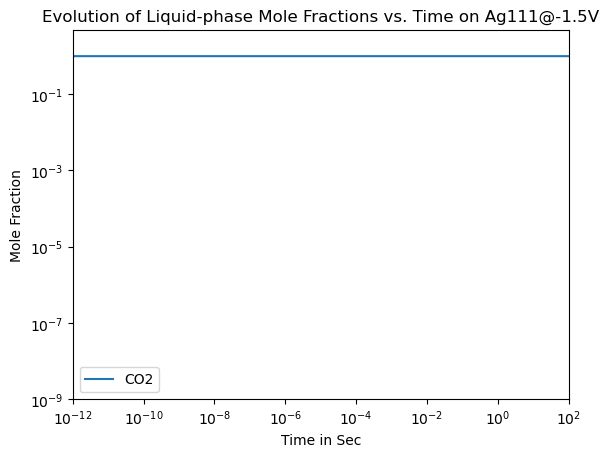

In [67]:
exclude_species = ["H2O"]
plotX(ssys.sims[1], 1e-6, 1e2, exclude_species)
xscale("log")
yscale("log")
xlim(1e-12, 1e2)
ylim(1e-9, 5)
title("Evolution of Liquid-phase Mole Fractions vs. Time on Ag111@-1.5V")
gcf()

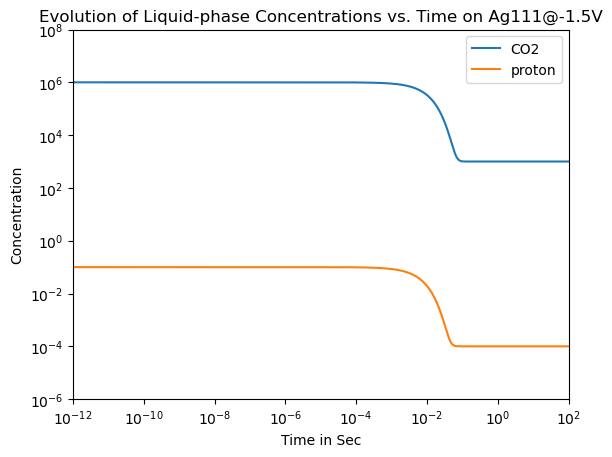

In [68]:
exclude_species = ["H2O"]
plotC(ssys.sims[1], 1e-6, 1e2, exclude_species)
xscale("log")
yscale("log")
xlim(1e-12, 1e2)
ylim(1e-6, 1e8)
title("Evolution of Liquid-phase Concentrations vs. Time on Ag111@-1.5V")
gcf()

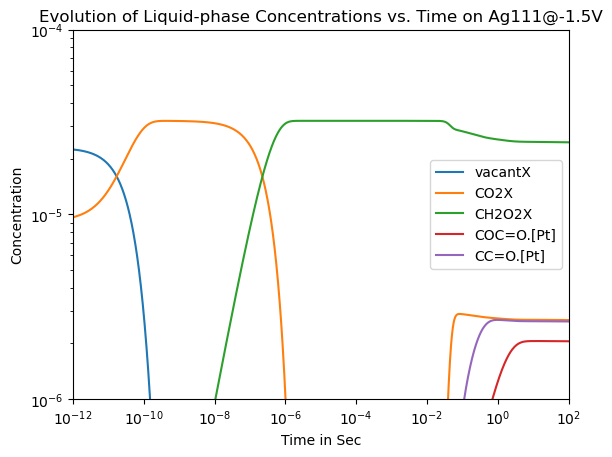

In [69]:
exclude_species = ["H2O"]
plotC(ssys.sims[2], 1e-6, 1e2, exclude_species)
xscale("log")
yscale("log")
xlim(1e-12, 1e2)
ylim(1e-6, 1e-4)
title("Evolution of Liquid-phase Concentrations vs. Time on Ag111@-1.5V")
gcf()

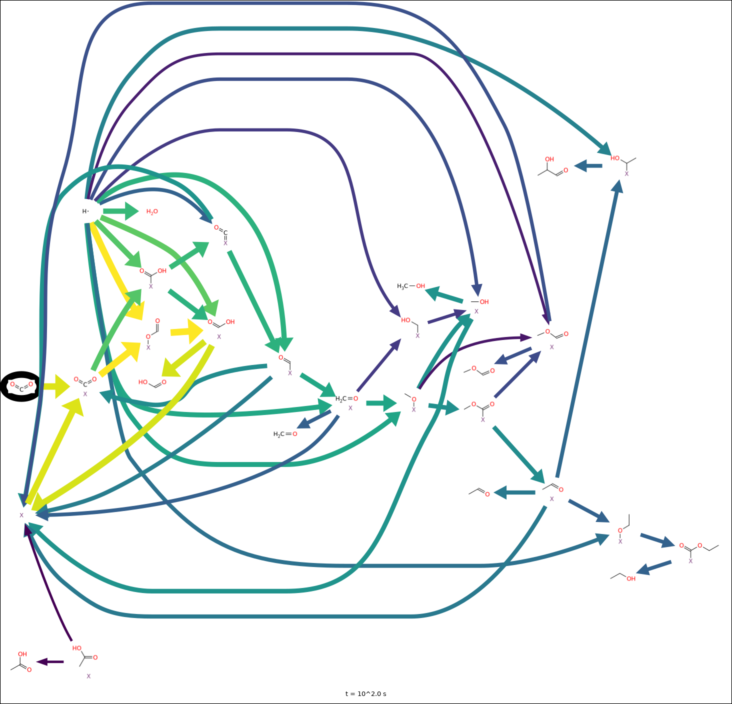

In [70]:
getfluxdiagram(ssys,1e2;speciesratetolerance=1e-6)

In [71]:
println(ssys.names)

["Ar", "He", "Ne", "N2", "CO2", "proton", "H", "C=O", "O=CO", "H2O", "O=CC=O", "H2", "OO", "CO", "O2", "O=C=C=O", "C=C=O", "O=C=CO", "CH4", "COC=O", "COO", "CO-2", "COOC", "O=CCO", "OCO", "COCO", "OCCO", "OC=CO", "O=O", "C=CO", "C=C", "O=C=C=C=O", "C#COO[CH2]", "C#COC[O]", "CC=O", "O=C=CC=O", "C=C(O)O", "CC(=O)O", "[OH]", "CC(=O)C=O", "COC(C)=O", "CC(=O)CO", "O=CCC=O", "COC=C=O", "O=C=CCO", "[CH2]OOC=C", "C=COC[O]", "C=CC=O", "C=COC=O", "O=CC=CO", "COC", "CCO", "CC(O)O", "CCOC=O", "COCC=O", "CCOO", "CC(C)=O", "C=C=C=O", "CC=C=O", "CC", "O=C=C=CO", "[CH2]OCC=O", "[O]CCC=O", "[CH2]COC=O", "[CH3]", "O=CCCO", "CCC=O", "CC(O)=C=O", "[CH]=O", "C[O]", "CC(O)C=O", "[CH2]O", "C=C(O)C=O", "OC=CCO", "C=CCO", "[CH]=C", "C[CH2]", "C=C=CO", "C=C=C", "C=C=C(O)O", "C=CC(=O)O", "CC=CO", "C=CC", "CC=C(O)O", "CCC(=O)O", "C=COO", "C#C", "C=COC", "C=CC(O)O", "C=COCO", "C=CCOO", "C=COOC", "CC(O)=CO", "C=C(C)O", "C#CC=O", "OC=C=CO", "CCOC", "CCCO", "CCC(O)O", "CCOCO", "CCCOO", "CCC", "CCOOC", "C=C=COO", "CC=

In [83]:
rops(ssys, "O=CO", 1e-12)

10962-element SparseArrays.SparseVector{Float64, Int64} with 17 stored entries:
  [10253]  =  1.81165e-7
  [10254]  =  2.86301e-26
  [10255]  =  -2.17534e-23
  [10256]  =  -6.02979e-30
  [10265]  =  1.19176e-22
  [10268]  =  1.18009e-22
  [10273]  =  2.99461e-24
           ⋮
  [10310]  =  -1.12058e-48
  [10352]  =  -9.82087e-28
  [10540]  =  -4.14154e-35
  [10555]  =  1.26353e-50
  [10835]  =  8.25969e-48
  [10865]  =  9.36983e-37
  [10867]  =  -1.9707e-52
  [10908]  =  3.09459e-35

In [72]:
plotrops(ssys,"CH2O2X",1;N=15,tol=0.0)

In [73]:
plotrops(ssys,"CHO2X",1;N=10,tol=0.0)

In [74]:
plotrops(ssys,"CO2HX",1;N=10,tol=0.0)

In [75]:
plotrops(ssys,"OX",1;N=10,tol=0.0)

In [76]:
plotrops(ssys,"OCX",1.0e-6)

In [77]:
for (i,rxn) in enumerate(inter.reactions)
    str = getrxnstr(rxn)
    kf = inter.kfs[i]
    krev = inter.krevs[i]
    Kc = kf/krev
    println(str)
    println("kf = $kf")
    println("krev = $krev")
    println("Kc = $Kc")
end

vacantX+CO2<=>CO2X
kf = 20654.615923781494
krev = 11189.298481041604
Kc = 1.8459259048971917
proton+CO2X<=>CHO2X
kf = 5.164749496653815e7
krev = 3.369038128826839e8
Kc = 0.1533004168893831
proton+CO2X<=>CO2HX
kf = 463658.8965294065
krev = 1.20318988446587e-5
Kc = 3.853580407511801e10
proton+CHO2X<=>CH2O2X
kf = 2.5e10
krev = 9.108706843764319e-26
Kc = 2.7446266993557504e35
proton+CO2HX<=>CH2O2X
kf = 1.9190551016885178e10
krev = 1.757621070775451e-14
Kc = 1.0918480289052538e24
proton+OCX<=>CHOX
kf = 2.5e10
krev = 2.604453583293511e-10
Kc = 9.59894242706594e19
proton+CHOX<=>CH2OX
kf = 1.7890196451453958e9
krev = 4.957912234830633e-11
Kc = 3.608413300616868e19
vacantX+vacantX+CO2<=>OX+OCX
kf = 3.0109478093923404e-24
krev = 3.037156297092479e15
Kc = 9.913707148607306e-40
OX+proton<=>HOX
kf = 2.5e10
krev = 4.7547181516587526e-14
Kc = 5.25793521352646e23
vacantX+C=O<=>CH2OX
kf = 500114.13488002896
krev = 399.6803280141717
Kc = 1251.2853393732605
proton+CHO2X<=>OX+C=O
kf = 7.971946163368602e-7

In [78]:
for (i,rxn) in enumerate(inter.reactions)
    str = getrxnstr(rxn)
    kf = inter.kfs[i]
    krev = inter.krevs[i]
    Kc = kf/krev
    println(str)
    println("kf = $kf")
    println("krev = $krev")
    println("Kc = $Kc")
end

vacantX+CO2<=>CO2X
kf = 20654.615923781494
krev = 11189.298481041604
Kc = 1.8459259048971917
proton+CO2X<=>CHO2X
kf = 5.164749496653815e7
krev = 3.369038128826839e8
Kc = 0.1533004168893831
proton+CO2X<=>CO2HX
kf = 463658.8965294065
krev = 1.20318988446587e-5
Kc = 3.853580407511801e10
proton+CHO2X<=>CH2O2X
kf = 2.5e10
krev = 9.108706843764319e-26
Kc = 2.7446266993557504e35
proton+CO2HX<=>CH2O2X
kf = 1.9190551016885178e10
krev = 1.757621070775451e-14
Kc = 1.0918480289052538e24
proton+OCX<=>CHOX
kf = 2.5e10
krev = 2.604453583293511e-10
Kc = 9.59894242706594e19
proton+CHOX<=>CH2OX
kf = 1.7890196451453958e9
krev = 4.957912234830633e-11
Kc = 3.608413300616868e19
vacantX+vacantX+CO2<=>OX+OCX
kf = 3.0109478093923404e-24
krev = 3.037156297092479e15
Kc = 9.913707148607306e-40
OX+proton<=>HOX
kf = 2.5e10
krev = 4.7547181516587526e-14
Kc = 5.25793521352646e23
vacantX+C=O<=>CH2OX
kf = 500114.13488002896
krev = 399.6803280141717
Kc = 1251.2853393732605
proton+CHO2X<=>OX+C=O
kf = 7.971946163368602e-7